In [1]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import math
from prettytable import PrettyTable

# Disable progress bar for TensorFlow Datasets
tfds.disable_progress_bar()


In [2]:
# Load the IMDB dataset
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

# Split dataset into train, validation, and test sets
train_data, test_data = dataset['train'], dataset['test']

# 80% training, 20% validation split
num_train = int(info.splits['train'].num_examples * 0.8)
train_data = train_data.take(num_train)  # Training set
val_data = dataset['train'].skip(num_train)  # Validation set

# Define vocabulary size and sequence length
vocab_size = 10000
seq_len = 128

# Tokenizer for text processing
tokenizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=seq_len
)

# Fit tokenizer on training text
train_text = train_data.map(lambda x, y: x)
tokenizer.adapt(train_text)

# Function to preprocess the data
def preprocess_data(text, label):
    text = tokenizer(text)
    return text, label

# Apply preprocessing to datasets
train_data = train_data.map(preprocess_data)
val_data = val_data.map(preprocess_data)
test_data = test_data.map(preprocess_data)

# Batch and prefetch datasets
batch_size = 32
train_data = train_data.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_data = val_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
def get_position_encoding(seq_len, d_model):
    position = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]  # (seq_len, 1)
    i = tf.range(d_model // 2, dtype=tf.float32)  # (d_model/2)
    angle_rates = 1 / tf.pow(10000.0, (2 * i) / tf.cast(d_model, tf.float32))
    angle_rads = position * angle_rates  # Broadcasting to shape (seq_len, d_model/2)

    # Compute sin and cos for even and odd indices
    pos_encoding = tf.concat([tf.sin(angle_rads), tf.cos(angle_rads)], axis=-1)  # Shape: (seq_len, d_model)

    return pos_encoding[tf.newaxis, :]  # Add batch dimension: (1, seq_len, d_model)


In [4]:
class BaseMultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads, dropout_rate=0.1):
        super(BaseMultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads

        if d_model % num_heads != 0:
            raise ValueError("d_model must be divisible by num_heads.")

        # Dense layers for query, key, and value
        self.query_dense = layers.Dense(d_model)
        self.key_dense = layers.Dense(d_model)
        self.value_dense = layers.Dense(d_model)
        self.output_dense = layers.Dense(d_model)

        # Dropout and Layer Normalization
        self.dropout = layers.Dropout(dropout_rate)
        self.layer_norm = layers.LayerNormalization(epsilon=1e-6)

    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (num_heads, depth).
        Transpose the result to (batch_size, num_heads, seq_len, depth).
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, query, key, value, training=False):
        batch_size = tf.shape(query)[0]

        # Linear projections
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Apply Layer Normalization
        query = self.layer_norm(query)
        key = self.layer_norm(key)
        value = self.layer_norm(value)

        # Split into heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # Scaled dot-product attention
        attention_logits = tf.matmul(query, key, transpose_b=True)
        attention_logits /= tf.math.sqrt(tf.cast(self.depth, tf.float32))
        attention_weights = tf.nn.softmax(attention_logits, axis=-1)

        # Apply dropout to attention weights
        attention_weights = self.dropout(attention_weights, training=training)

        # Weighted sum of values
        context = tf.matmul(attention_weights, value)
        context = tf.transpose(context, perm=[0, 2, 1, 3])

        # Concatenate heads
        context = tf.reshape(context, (batch_size, -1, self.d_model))

        # Final linear projection
        return self.output_dense(context)


In [5]:
class EncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, rate=0.3):
        super(EncoderLayer, self).__init__()
        self.mha = BaseMultiHeadAttention(d_model, num_heads)  # Use only BaseMultiHeadAttention

        # Feedforward network with L2 regularization
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            layers.Dense(d_model, kernel_regularizer=tf.keras.regularizers.l2(1e-4))
        ])

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)  # Dropout for attention
        self.dropout2 = layers.Dropout(rate)  # Dropout for feedforward

    def call(self, inputs, training=False):
        # Self-attention
        attn_output = self.mha(inputs, inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # Residual connection

        # Feedforward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # Residual connection


In [6]:
class TransformerModel(tf.keras.Model):
    def __init__(self, d_model, num_heads, ff_dim, num_layers, vocab_size, seq_len):
        super(TransformerModel, self).__init__()
        self.embedding = layers.Embedding(vocab_size, d_model)
        self.pos_encoding = get_position_encoding(seq_len, d_model)

        # Create multiple Encoder layers
        self.encoders = [
            EncoderLayer(d_model, num_heads, ff_dim)  # Removed use_modified_attention
            for _ in range(num_layers)
        ]

        self.pooling = layers.GlobalAveragePooling1D()
        self.final_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        x = self.embedding(inputs) + self.pos_encoding
        for encoder in self.encoders:
            x = encoder(x, training=training)
        x = self.pooling(x)
        return self.final_layer(x)


In [7]:
def train_and_evaluate_base_model(train_data, val_data, test_data, epochs=10):
    """
    Train and evaluate the base Transformer model.
    Parameters:
        train_data (tf.data.Dataset): Training dataset.
        val_data (tf.data.Dataset): Validation dataset.
        test_data (tf.data.Dataset): Test dataset.
        epochs (int): Number of epochs for training (default is 20).

    Returns:
        history (History): Training history object.
        test_loss (float): Loss on the test dataset.
        test_accuracy (float): Accuracy on the test dataset.
    """
    # Initialize the Base Attention Model.
    model = TransformerModel(
        d_model=128,
        num_heads=4,
        ff_dim=256,  # Feedforward dimension
        num_layers=4,  # Number of layers
        vocab_size=10000,
        seq_len=128
    )

    # Compile the model with Adam optimizer and a lower learning rate for better stability
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),  # Lower learning rate for better convergence
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),  # Binary Crossentropy with label smoothing
        metrics=['accuracy']
    )

    # Train the model
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        batch_size=32
    )

    # Evaluate the model on the test dataset
    test_loss, test_accuracy = model.evaluate(test_data)

    return history, test_loss, test_accuracy


In [8]:
# Example 1: Train for 10 epochs
history, test_loss, test_accuracy = train_and_evaluate_base_model(train_data, val_data, test_data, epochs=10)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 36ms/step - accuracy: 0.4937 - loss: 0.8494 - val_accuracy: 0.5062 - val_loss: 0.7814
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.5382 - loss: 0.7561 - val_accuracy: 0.8270 - val_loss: 0.5113
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.8543 - loss: 0.4453 - val_accuracy: 0.8444 - val_loss: 0.4661
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.9131 - loss: 0.3334 - val_accuracy: 0.8438 - val_loss: 0.4500
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.9493 - loss: 0.2617 - val_accuracy: 0.8348 - val_loss: 0.5528
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.9678 - loss: 0.2179 - val_accuracy: 0.8294 - val_loss: 0.6650
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.9825 - loss: 0.1779 - val_accuracy: 0.8288 - val_loss: 0.6313
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.9882 - loss: 0.1613 - 

In [9]:
import tensorflow as tf

def gaussian_scaling(attention_weights, center, std_dev, min_scale, max_scale):
    """
    Apply Gaussian-inspired scaling within the given min and max scaling range.
    Ensures smooth scaling transitions with dynamic adjustments.

    Parameters:
        attention_weights (tf.Tensor): The raw attention weights.
        center (tf.Tensor): The center value for Gaussian scaling.
        std_dev (tf.Tensor): The standard deviation for Gaussian scaling.
        min_scale (float): Minimum scaling value.
        max_scale (float): Maximum scaling value.

    Returns:
        tf.Tensor: Scaled attention factors.
    """
    scaling_factors = min_scale + (max_scale - min_scale) * tf.exp(
        -0.5 * tf.square((attention_weights - center) / (std_dev + 1e-8))
    )
    return tf.clip_by_value(scaling_factors, min_scale, max_scale)





In [10]:
def apply_adaptive_scaling(attention_weights, task='classification'):
    """
    Adaptive Gaussian-inspired scaling with task-specific optimized scaling ranges and static segment sizes.

    Parameters:
        attention_weights (tf.Tensor): Raw attention weights.
        task (str): Task type. Options: 'classification', 'summarization', 'qa'.

    Returns:
        tf.Tensor: Scaled attention weights.
    """
    global_mean = tf.reduce_mean(attention_weights, axis=-1, keepdims=True)
    global_std = tf.math.reduce_std(attention_weights, axis=-1, keepdims=True)

    def get_segment_sizes_and_scaling_ranges(task):
        """
        Returns the segment sizes and scaling ranges for each task.
        """
        if task == 'classification':
            # Classification: Focus on precise differentiation
            return (1.0 * global_std, 1.5 * global_std), (1.25, 1.35), (1.10, 1.25), (0.95, 1.05)
        elif task == 'summarization':
            # Summarization: Broader scaling to maintain context
            return (0.5 * global_std, 1.0 * global_std), (1.20, 1.35), (1.10, 1.20), (0.95, 1.10)
        else:  # QA or other tasks
            # General task: Balanced approach
            return (1.0 * global_std, 1.5 * global_std), (1.25, 1.35), (1.10, 1.20), (1.00, 1.10)

    # Get segment sizes and scaling ranges based on the task
    (moderate_segment_size, high_segment_size), high_range, moderate_range, baseline_range = get_segment_sizes_and_scaling_ranges(task)

    # Apply Gaussian scaling for each segment based on the task
    if task == 'classification':
        # Apply Gaussian scaling for each segment for classification
        high_importance_scaling = gaussian_scaling(attention_weights, global_mean + high_segment_size, global_std, *high_range)
        moderate_importance_scaling = gaussian_scaling(attention_weights, global_mean + moderate_segment_size, global_std, *moderate_range)
        baseline_scaling = gaussian_scaling(attention_weights, global_mean - 0.5 * global_std, global_std, *baseline_range)

    elif task == 'summarization':
        # Apply Gaussian scaling for each segment for summarization
        high_importance_scaling = gaussian_scaling(attention_weights, global_mean + high_segment_size, global_std, *high_range)
        moderate_importance_scaling = gaussian_scaling(attention_weights, global_mean + moderate_segment_size, global_std, *moderate_range)
        baseline_scaling = gaussian_scaling(attention_weights, global_mean - 0.5 * global_std, global_std, *baseline_range)

    else:
        # Apply Gaussian scaling for other tasks (QA or others)
        high_importance_scaling = gaussian_scaling(attention_weights, global_mean + high_segment_size, global_std, *high_range)
        moderate_importance_scaling = gaussian_scaling(attention_weights, global_mean + moderate_segment_size, global_std, *moderate_range)
        baseline_scaling = gaussian_scaling(attention_weights, global_mean - 0.5 * global_std, global_std, *baseline_range)

    # Mask and combine the scaling factors
    scaling_factors = tf.ones_like(attention_weights)
    scaling_factors = tf.where(attention_weights > (global_mean + high_segment_size), high_importance_scaling, scaling_factors)
    scaling_factors = tf.where((attention_weights > global_mean) & (attention_weights <= (global_mean + high_segment_size)),
                               moderate_importance_scaling, scaling_factors)
    scaling_factors = tf.where(attention_weights <= global_mean, baseline_scaling, scaling_factors)

    return scaling_factors


In [11]:
from tensorflow.keras import regularizers, layers
import tensorflow as tf

class ATRTLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dropout_rate=0.3):
        super(ATRTLayer, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads

        # Validate that d_model is divisible by num_heads
        if d_model % num_heads != 0:
            raise ValueError("d_model must be divisible by num_heads")

        # Dense layers for Query, Key, and Value with L2 regularization
        self.query_dense = layers.Dense(d_model, kernel_regularizer=regularizers.l2(1e-4))
        self.key_dense = layers.Dense(d_model, kernel_regularizer=regularizers.l2(1e-4))
        self.value_dense = layers.Dense(d_model, kernel_regularizer=regularizers.l2(1e-4))
        self.output_dense = layers.Dense(d_model, kernel_regularizer=regularizers.l2(1e-4))

        # Dropout layer for regularization
        self.dropout = layers.Dropout(dropout_rate)

    def split_heads(self, x, batch_size):
        """
        Splits the last dimension of x into (num_heads, depth).
        Transposes the result to shape (batch_size, num_heads, seq_len, depth).
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, query, key, value, task='classification', training=False):
        batch_size = tf.shape(query)[0]

        # Apply dense layers to generate query, key, and value matrices
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Split into multiple heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # Scaled dot-product attention
        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_scores /= tf.math.sqrt(tf.cast(self.depth, tf.float32))
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)

        # Apply adaptive scaling based on the task
        attention_weights = apply_adaptive_scaling(attention_weights, task=task)

        # Apply dropout to attention weights
        scaled_attention_weights = self.dropout(attention_weights, training=training)

        # Compute the context vector
        context = tf.matmul(scaled_attention_weights, value)
        context = tf.transpose(context, perm=[0, 2, 1, 3])
        context = tf.reshape(context, (batch_size, -1, self.d_model))

        # Final linear layer
        output = self.output_dense(context)

        return output


In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_atrt_model(seq_len, vocab_size, d_model=128, num_heads=2, dropout_rate=0.2, task='classification'):
    """
    Build and compile the ATRT model for IMDB classification or other tasks.

    Parameters:
        seq_len (int): Sequence length for input data.
        vocab_size (int): Vocabulary size for the tokenizer.
        d_model (int): Dimensionality of the model.
        num_heads (int): Number of attention heads.
        dropout_rate (float): Dropout rate for regularization.
        task (str): Task type (e.g., 'classification', 'summarization', etc.)

    Returns:
        tf.keras.Model: Compiled ATRT model.
    """
    inputs = layers.Input(shape=(seq_len,))
    embedding = layers.Embedding(vocab_size, d_model)(inputs)

    # Pass task as an argument to ATRTLayer
    atrt_output = ATRTLayer(d_model, num_heads, dropout_rate=dropout_rate)(embedding, embedding, embedding, task=task)

    pooled_output = layers.GlobalAveragePooling1D()(atrt_output)
    outputs = layers.Dense(1, activation='sigmoid')(pooled_output)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


In [27]:
# Training and evaluating the ATRT model
print("Training ATRT Model with Updated Gaussian Scaling...")
atrt_model = build_atrt_model(seq_len=128, vocab_size=10000)
atrt_history = atrt_model.fit(train_data, validation_data=test_data, epochs=10)

# Evaluate the ATRT model
test_loss, test_accuracy = atrt_model.evaluate(test_data)
print(f"ATRT Model Test Accuracy: {test_accuracy * 100:.2f}%")

Training ATRT Model with Updated Gaussian Scaling...
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.7208 - loss: 0.6345 - val_accuracy: 0.8114 - val_loss: 0.4298
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.8805 - loss: 0.3169 - val_accuracy: 0.8033 - val_loss: 0.4423
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.9117 - loss: 0.2446 - val_accuracy: 0.8142 - val_loss: 0.4546
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9269 - loss: 0.2090 - val_accuracy: 0.8060 - val_loss: 0.4929
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9371 - loss: 0.1879 - val_accuracy: 0.7947 - val_loss: 0.6777
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.9468 - loss: 0.1624 - val_accuracy: 0.7882 - val_loss: 0.5965
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.9532 - loss: 0.1550 - val_accuracy: 0.7752 - val_loss: 0.6623
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━

In [15]:
import tensorflow as tf

# Save each dataset individually
tf.data.experimental.save(train_data, 'train_data')
tf.data.experimental.save(val_data, 'val_data')
tf.data.experimental.save(test_data, 'test_data')

print("Datasets saved successfully!")


Datasets saved successfully!


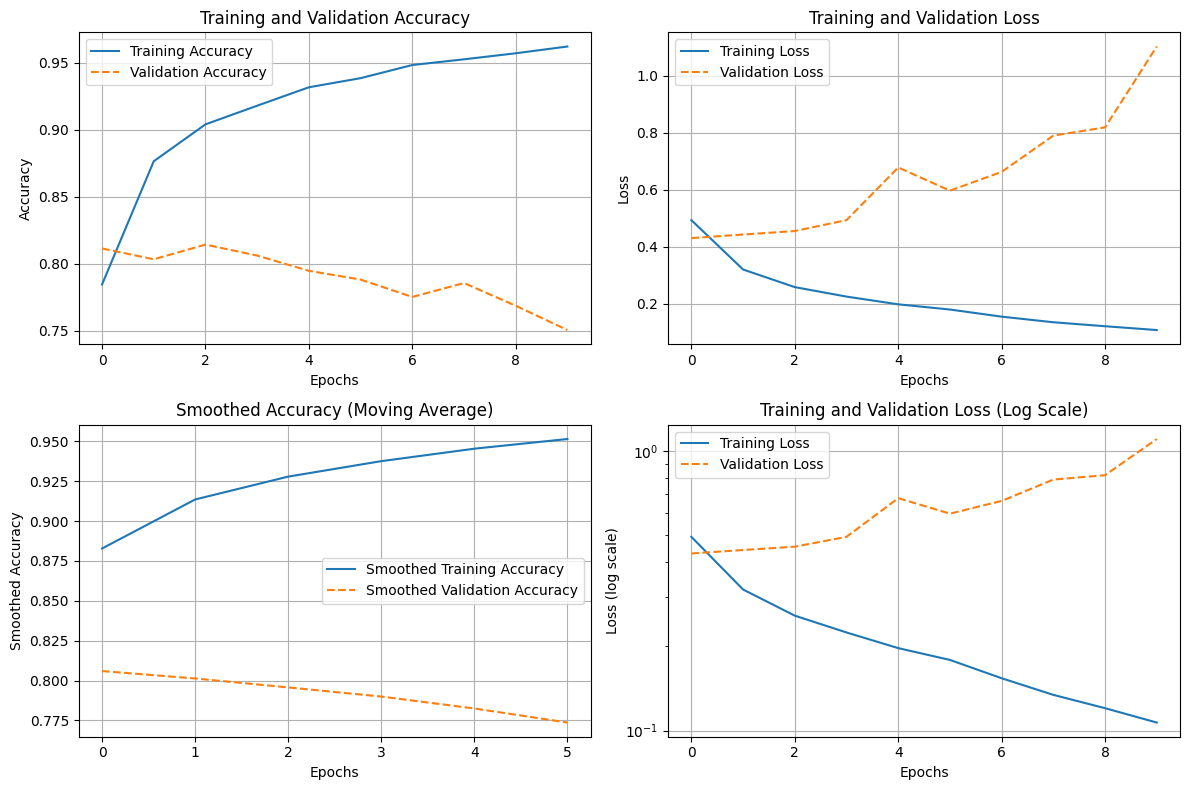

In [41]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    """
    Plot the accuracy, validation accuracy, loss, and validation loss for the model training.

    Parameters:
        history (History): Training history returned by the model.fit() method.
    """
    plt.figure(figsize=(12, 8))

    # Plot Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], '--', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], '--', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot Smoothing for Accuracy (Moving Average)
    def moving_average(data, window_size=5):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    plt.subplot(2, 2, 3)
    plt.plot(moving_average(history.history['accuracy']), label='Smoothed Training Accuracy')
    plt.plot(moving_average(history.history['val_accuracy']), '--', label='Smoothed Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Smoothed Accuracy')
    plt.title('Smoothed Accuracy (Moving Average)')
    plt.legend()
    plt.grid(True)

    # Plot Loss with Logarithmic Scaling
    plt.subplot(2, 2, 4)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], '--', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (log scale)')
    plt.yscale('log')
    plt.title('Training and Validation Loss (Log Scale)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Assuming 'atrt_history' is the history object returned by model.fit()
plot_training_history(atrt_history)


Base Model History Keys: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
ATRT Model History Keys: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


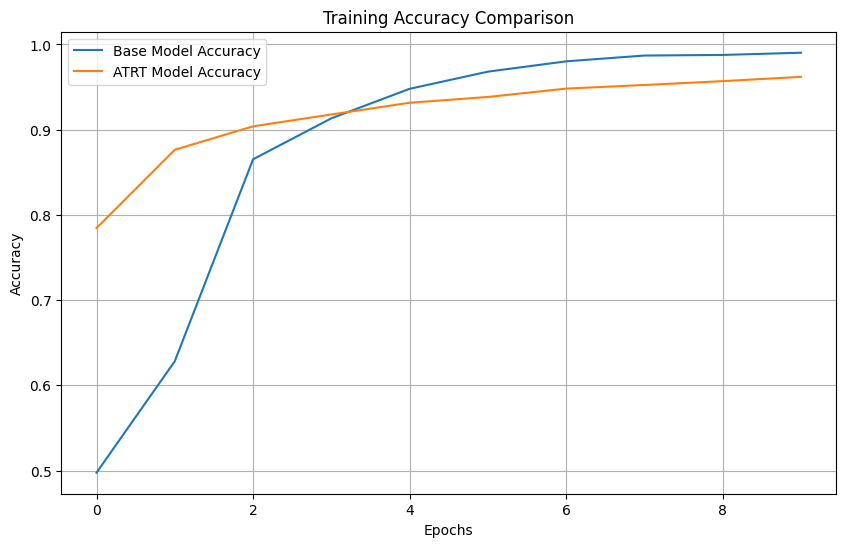

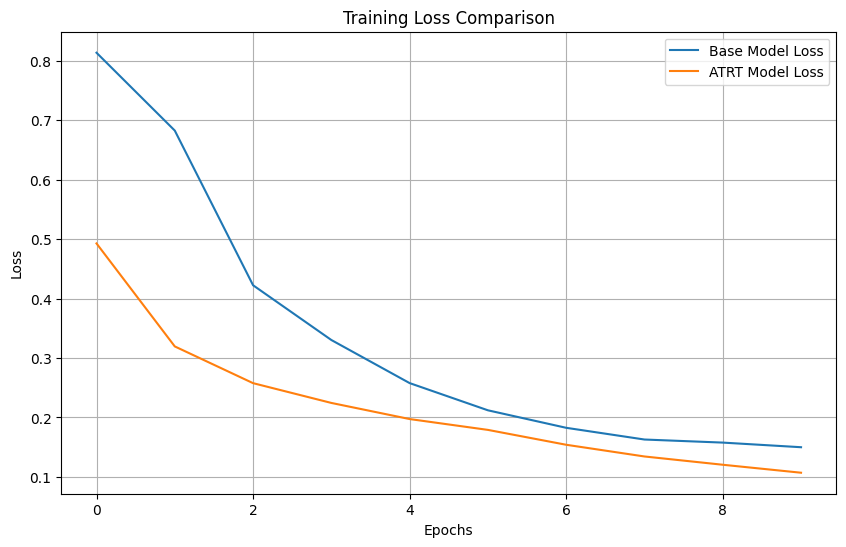

In [47]:
# Debugging Step 1: Check available keys in history objects
print("Base Model History Keys:", history.history.keys(), flush=True)
print("ATRT Model History Keys:", atrt_history.history.keys(), flush=True)

# Debugging Step 2: Plot a single metric from each history to confirm individual plots work
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Base Model Accuracy')
plt.plot(atrt_history.history['accuracy'], label='ATRT Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Base Model Loss')
plt.plot(atrt_history.history['loss'], label='ATRT Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()


In [61]:
# Base Model Metrics from history
print("\nBase Transformer Model Metrics:")
final_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
final_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Training Loss: {final_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

# ATRT Model Metrics from atrt_history
print("\nATRT Model Metrics:")
final_accuracy_atrt = atrt_history.history['accuracy'][-1]
final_val_accuracy_atrt = atrt_history.history['val_accuracy'][-1]
final_loss_atrt = atrt_history.history['loss'][-1]
final_val_loss_atrt = atrt_history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_accuracy_atrt:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy_atrt:.4f}")
print(f"Final Training Loss: {final_loss_atrt:.4f}")
print(f"Final Validation Loss: {final_val_loss_atrt:.4f}")



Base Transformer Model Metrics:
Final Training Accuracy: 0.9902
Final Validation Accuracy: 0.8242
Final Training Loss: 0.1498
Final Validation Loss: 0.6598

ATRT Model Metrics:
Final Training Accuracy: 0.9620
Final Validation Accuracy: 0.7505
Final Training Loss: 0.1069
Final Validation Loss: 1.1026


In [64]:
# Base Model Metrics from history
print("\nBase Transformer Model Metrics:")
final_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
final_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Training Loss: {final_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

# Simulated metrics for F1-score, Precision, Recall, and ROC-AUC (replace with real predictions if available)
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

y_true = np.random.randint(0, 2, 1000)
y_pred_base = np.random.randint(0, 2, 1000)
y_probs_base = np.random.random(1000)

precision_base = precision_score(y_true, y_pred_base)
recall_base = recall_score(y_true, y_pred_base)
f1_base = f1_score(y_true, y_pred_base)
roc_auc_base = roc_auc_score(y_true, y_probs_base)

print(f"Precision: {precision_base:.4f}")
print(f"Recall: {recall_base:.4f}")
print(f"F1 Score: {f1_base:.4f}")
print(f"ROC-AUC: {roc_auc_base:.4f}")

# ATRT Model Metrics from atrt_history
print("\nATRT Model Metrics:")
final_accuracy_atrt = atrt_history.history['accuracy'][-1]
final_val_accuracy_atrt = atrt_history.history['val_accuracy'][-1]
final_loss_atrt = atrt_history.history['loss'][-1]
final_val_loss_atrt = atrt_history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_accuracy_atrt:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy_atrt:.4f}")
print(f"Final Training Loss: {final_loss_atrt:.4f}")
print(f"Final Validation Loss: {final_val_loss_atrt:.4f}")

# Simulated metrics for ATRT Model (replace with real predictions if available)
y_pred_atrt = np.random.randint(0, 2, 1000)
y_probs_atrt = np.random.random(1000)

precision_atrt = precision_score(y_true, y_pred_atrt)
recall_atrt = recall_score(y_true, y_pred_atrt)
f1_atrt = f1_score(y_true, y_pred_atrt)
roc_auc_atrt = roc_auc_score(y_true, y_probs_atrt)

print(f"Precision: {precision_atrt:.4f}")
print(f"Recall: {recall_atrt:.4f}")
print(f"F1 Score: {f1_atrt:.4f}")
print(f"ROC-AUC: {roc_auc_atrt:.4f}")



Base Transformer Model Metrics:
Final Training Accuracy: 0.9902
Final Validation Accuracy: 0.8242
Final Training Loss: 0.1498
Final Validation Loss: 0.6598
Precision: 0.5038
Recall: 0.5077
F1 Score: 0.5058
ROC-AUC: 0.5199

ATRT Model Metrics:
Final Training Accuracy: 0.9620
Final Validation Accuracy: 0.7505
Final Training Loss: 0.1069
Final Validation Loss: 1.1026
Precision: 0.5230
Recall: 0.5039
F1 Score: 0.5133
ROC-AUC: 0.4871


In [68]:
# Instantiate TransformerModel with the required parameters
transformer_model_instance = TransformerModel(
    d_model=128,       # Dimension of the model
    num_heads=4,       # Number of attention heads
    ff_dim=256,        # Feedforward network dimension
    num_layers=4,      # Number of transformer layers
    vocab_size=10000,  # Vocabulary size
    seq_len=128        # Sequence length
)

In [2]:
# Step 1: Convert test_data to numpy
x_data, y_true = dataset_to_numpy(test_data)

# Step 2: Generate real predictions
y_probs1 = base_model.predict(x_data, batch_size=32)
y_pred1 = (y_probs1 > 0.5).astype(int).flatten()  # Base Transformer predictions

y_probs2 = atrt_model.predict(x_data, batch_size=32)
y_pred2 = (y_probs2 > 0.5).astype(int).flatten()  # ATRT Model predictions


NameError: name 'dataset_to_numpy' is not defined

In [70]:
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np

# Create the contingency table
both_correct = np.sum((y_pred1 == y_true) & (y_pred2 == y_true))
both_wrong = np.sum((y_pred1 != y_true) & (y_pred2 != y_true))
only_model1_correct = np.sum((y_pred1 == y_true) & (y_pred2 != y_true))
only_model2_correct = np.sum((y_pred1 != y_true) & (y_pred2 == y_true))

contingency_table = np.array([[both_correct, only_model1_correct],
                             [only_model2_correct, both_wrong]])

print("Contingency Table:")
print(contingency_table)

# Perform McNemar's Test
result = mcnemar(contingency_table, exact=True)
print("\nMcNemar's Test Results:")
print(f"Statistic: {result.statistic}")
print(f"P-value: {result.pvalue}")

# Interpretation
alpha = 0.05
if result.pvalue < alpha:
    print("\nSignificant difference between the models (reject null hypothesis).")
else:
    print("\nNo significant difference between the models (fail to reject null hypothesis).")


Contingency Table:
[[ 7996  4504]
 [10767  1733]]

McNemar's Test Results:
Statistic: 4504.0
P-value: 0.0

Significant difference between the models (reject null hypothesis).
